## Quantization Debugger

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import tensorflow_hub as hub

### Boilerplates and helpers

In [3]:
MODEL_URI = 'https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5'


def process_image(data):
  data['image'] = tf.image.resize(data['image'], (224, 224)) / 255.0
  return data


# Representative dataset
def representative_dataset(dataset):

  def _data_gen():
    for data in dataset.batch(1):
      yield [data['image']]

  return _data_gen


def eval_tflite(tflite_model, dataset):
  """Evaluates tensorflow lite classification model with the given dataset."""
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_idx = interpreter.get_input_details()[0]['index']
  output_idx = interpreter.get_output_details()[0]['index']

  results = []

  for data in representative_dataset(dataset)():
    interpreter.set_tensor(input_idx, data[0])
    interpreter.invoke()
    results.append(interpreter.get_tensor(output_idx).flatten())

  results = np.array(results)
  gt_labels = np.array(list(dataset.map(lambda data: data['label'] + 1)))
  accuracy = (
      np.sum(np.argsort(results, axis=1)[:, -5:] == gt_labels.reshape(-1, 1)) /
      gt_labels.size)
  print(f'Top-5 accuracy (quantized): {accuracy * 100:.2f}%')


model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(224, 224, 3), batch_size=1),
  hub.KerasLayer(MODEL_URI)
])
model.compile(
    loss='sparse_categorical_crossentropy',
    metrics='sparse_top_k_categorical_accuracy')
model.build([1, 224, 224, 3])

# Prepare dataset with 100 examples
ds = tfds.load('imagenet_v2', split='test[:1%]')
ds = ds.map(process_image)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.representative_dataset = representative_dataset(ds)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_model = converter.convert()

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [4]:
test_ds = ds.map(lambda data: (data['image'], data['label'] + 1)).batch(16)
loss, acc = model.evaluate(test_ds)
print(f'Top-5 accuracy (float): {acc * 100:.2f}%')

7/7 [==============================] - 3s 170ms/step - loss: 5.7098 - sparse_top_k_categorical_accuracy: 0.8200
Top-5 accuracy (float): 82.00%


In [5]:
eval_tflite(quantized_model, ds)

Top-5 accuracy (quantized): 55.00%


### Step 1. Debugger preparation

In [6]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset(ds)

# my_debug_dataset should have the same format as my_representative_dataset
debugger = tf.lite.experimental.QuantizationDebugger(
    converter = converter,
    debug_dataset = representative_dataset(ds)
)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


### Step 2. Running the debugger and getting the results

In [7]:
debugger.run()

In [9]:
RESULTS_FILE = '/tmp/debugger_results.csv'
with open(RESULTS_FILE, 'w') as f:
    debugger.layer_statistics_dump(f)

In [10]:
!head /tmp/debugger_results.csv

op_name,tensor_idx,num_elements,stddev,mean_error,max_abs_error,mean_squared_error,scale,zero_point,tensor_name
MUL,227,150528.0,0.0038074458,-1.5289947e-06,0.007843149,1.4592691e-05,0.011764706,-43,predict/hub_input/Mul;predict/hub_input/Mul
SUB,231,150528.0,0.0018521445,0.0014028883,0.0039216266,5.5015644e-06,0.007843138,-1,predict/hub_input/Sub;predict/hub_input/Sub
CONV_2D,235,200704.0,0.04148447,0.00021330711,0.10219054,0.001726107,0.14247456,-30,predict/MobilenetV3/Conv/BatchNorm/FusedBatchNormV3;predict/MobilenetV3/Conv/BatchNorm/FusedBatchNormV3;predict/MobilenetV3/expanded_conv/project/Conv2D;predict/MobilenetV3/expanded_conv/project/Conv2D;predict/MobilenetV3/Conv/Conv2D;predict/MobilenetV3/Conv/Conv2D
HARD_SWISH,239,200704.0,0.029809669,-0.00045437342,0.045248985,0.000892947,0.08929687,-124,predict/MobilenetV3/Conv/hard_swish/mul_1;predict/MobilenetV3/Conv/hard_swish/mul_1;predict/MobilenetV3/Conv/hard_swish/add/y;predict/MobilenetV3/Conv/hard_swish/add/y;predict/MobilenetV3

In [11]:
layer_stats = pd.read_csv(RESULTS_FILE)
layer_stats.head()

,op_name,tensor_idx,num_elements,stddev,mean_error,max_abs_error,mean_squared_error,scale,zero_point,tensor_name
0,MUL,227,150528.0,0.003807,-0.000002,0.007843,0.000015,0.011765,-43,predict/hub_input/Mul;predict/hub_input/Mul
1,SUB,231,150528.0,0.001852,0.001403,0.003922,0.000006,0.007843,-1,predict/hub_input/Sub;predict/hub_input/Sub
2,CONV_2D,235,200704.0,0.041484,0.000213,0.102191,0.001726,0.142475,-30,predict/MobilenetV3/Conv/BatchNorm/FusedBatchN...
3,HARD_SWISH,239,200704.0,0.029810,-0.000454,0.045249,0.000893,0.089297,-124,predict/MobilenetV3/Conv/hard_swish/mul_1;pred...
4,DEPTHWISE_CONV_2D,243,50176.0,0.217587,-0.022635,0.724764,0.047929,0.508746,-128,predict/MobilenetV3/expanded_conv/depthwise/Re...


### Step 3. Data analysis

In [13]:
layer_stats['range'] = 255.0*layer_stats['scale']
layer_stats['rmse/scale'] = layer_stats.apply(
    lambda row: np.sqrt(row['mean_squared_error'])/row['scale'], axis = 1)
layer_stats[['op_name', 'range', 'rmse/scale']].head()

,op_name,range,rmse/scale
0,MUL,3.000000,0.324703
1,SUB,2.000000,0.299056
2,CONV_2D,36.331013,0.291606
3,HARD_SWISH,22.770702,0.334639
4,DEPTHWISE_CONV_2D,129.730222,0.430326


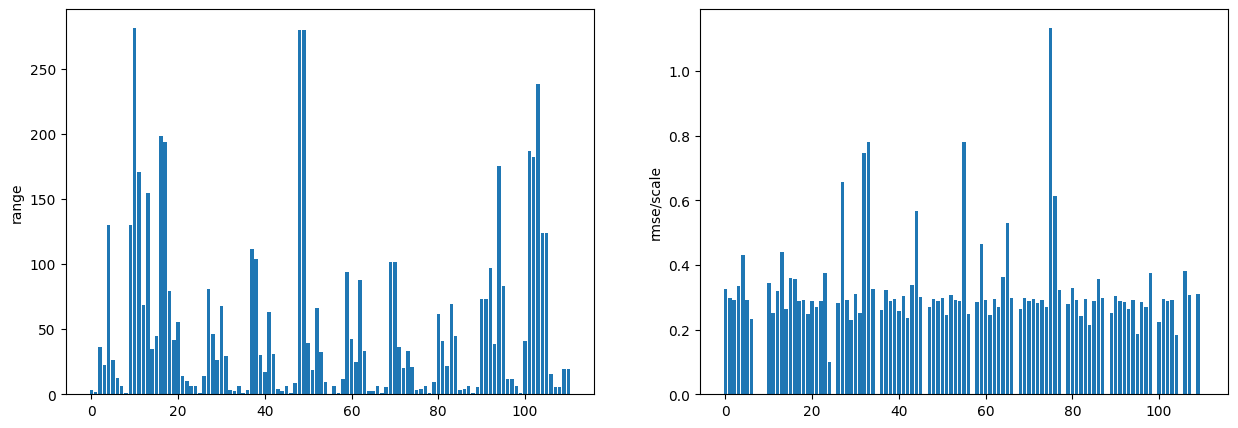

In [14]:
plt.figure(figsize=(15, 5))
ax1 = plt.subplot(121)
ax1.bar(np.arange(len(layer_stats)), layer_stats['range'])
ax1.set_ylabel('range')
ax2 = plt.subplot(122)
ax2.bar(np.arange(len(layer_stats)), layer_stats['rmse/scale'])
ax2.set_ylabel('rmse/scale')
plt.show()

In [15]:
layer_stats[layer_stats['rmse/scale'] > 0.7][[
    'op_name', 'range', 'rmse/scale', 'tensor_name'
]]

,op_name,range,rmse/scale,tensor_name
32,MEAN,3.300808,0.747206,predict/MobilenetV3/expanded_conv_4/squeeze_ex...
33,CONV_2D,2.866468,0.778941,predict/MobilenetV3/expanded_conv_4/squeeze_ex...
55,CONV_2D,0.001957,0.780575,predict/MobilenetV3/expanded_conv_6/squeeze_ex...
75,MEAN,3.214617,1.134344,predict/MobilenetV3/expanded_conv_8/squeeze_ex...


In [16]:
suspected_layers = list(
    layer_stats[layer_stats['rmse/scale'] > 0.7]['tensor_name'])

In [17]:
suspected_layers.extend(list(layer_stats[:5]['tensor_name']))

## Selective Quantization

In [18]:
debug_options = tf.lite.experimental.QuantizationDebugOptions(
    denylisted_nodes=suspected_layers)
debugger = tf.lite.experimental.QuantizationDebugger(
    converter=converter,
    debug_dataset=representative_dataset(ds),
    debug_options=debug_options)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [19]:
selective_quantized_model = debugger.get_nondebug_quantized_model()
eval_tflite(selective_quantized_model, ds)

Top-5 accuracy (quantized): 65.00%


In [20]:
debug_options = tf.lite.experimental.QuantizationDebugOptions(
    denylisted_ops=['MEAN'])
debugger = tf.lite.experimental.QuantizationDebugger(
    converter=converter,
    debug_dataset=representative_dataset(ds),
    debug_options=debug_options)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [21]:
selective_quantized_model = debugger.get_nondebug_quantized_model()
eval_tflite(selective_quantized_model, ds)

Top-5 accuracy (quantized): 55.00%


In [22]:
debug_options = tf.lite.experimental.QuantizationDebugOptions(
    layer_debug_metrics={
        'mean_abs_error': (lambda diff: np.mean(np.abs(diff)))
    },
    layer_direct_compare_metrics={
        'correlation':
            lambda f, q, s, zp: (np.corrcoef(f.flatten(),
                                             (q.flatten() - zp) / s)[0, 1])
    },
    model_debug_metrics={
        'argmax_accuracy': (lambda f, q: np.mean(np.argmax(f) == np.argmax(q)))
    })

debugger = tf.lite.experimental.QuantizationDebugger(
    converter=converter,
    debug_dataset=representative_dataset(ds),
    debug_options=debug_options)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [23]:
debugger.run()

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2674: RuntimeWarning: invalid value encountered in cast
  X = array(m, ndmin=2, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/tools/optimize/debugging/python/debugger.py:382: RuntimeWarning: Mean of empty slice
  metrics[metric_name] = np.nanmean(metrics[metric_name])


In [24]:
CUSTOM_RESULTS_FILE = '/tmp/debugger_results.csv'
with open(CUSTOM_RESULTS_FILE, 'w') as f:
  debugger.layer_statistics_dump(f)

custom_layer_stats = pd.read_csv(CUSTOM_RESULTS_FILE)
custom_layer_stats[['op_name', 'mean_abs_error', 'correlation']].tail()

,op_name,mean_abs_error,correlation
106,CONV_2D,1.887783e-02,0.010363
107,HARD_SWISH,5.638206e-03,0.002661
108,AVERAGE_POOL_2D,5.105026e-08,0.901535
109,CONV_2D,2.019732e-02,0.992227
110,RESHAPE,1.003777e-07,0.992396
